# Feature Engineering  and Model Training

Based on the train and test sentence data in the last step, we will do the feature engineering and train the language detection model in this step. Here are some keys in this part:

#### 1. Feature Engineering with N-gram model
#### 2. Hyperparameter tuning (the value of N)
#### 3. Language detection model building with Naive Bayes model

## Feature Engineering with N-gram model

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import random
from datetime import datetime
import os
print(os.listdir("../input"))

['__results___files', 'train_validation_data.pkl', 'custom.css', '__results__.html', '__output__.json', 'language_sentence.pkl']


First, we read the train and validation sentence data.

In [2]:
f = open('../input/train_validation_data.pkl','rb')
data = pickle.load(f)
f.close()
data.keys()

dict_keys(['train_x', 'train_y', 'val_x', 'val_y'])

In [3]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB 
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

Based on the literature 'Improved Text Language Identification for the South African Languages' [1] and Google Compact Language Detector 2 [2], we decide use `N-gram + Naive Bayes` model to build the language detection engineer.

* [1] Duvenhage, Bernardt, Mfundo Ntini, and Phala Ramonyai. "Improved text language identification for the South African languages." Pattern Recognition Association of South Africa and Robotics and Mechatronics (PRASA-RobMech), 2017. IEEE, 2017.
* [2] https://github.com/CLD2Owners/cld2

In `scikit-learn` package, there are two models `TfidfVectorizer` and `CountVectorizer` that can be used to do N-gram feature extraction.

`CountVectorizer` model will convert a collection of text documents to a matrix of token counts. This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix and the number of features will be equal to the vocabulary size found by analyzing the data.

`TfidfVectorizer` model will transform a count matrix to a normalized tf or tf-idf representation. Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency.  The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.  This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix and the number of features will be equal to the vocabulary size found by analyzing the data.

Here we will use `TfidfVectorizer` model. The `CountVectorizer` only considers the frequency at which each vocabulary appears in the training text, while the `TfidfVectorizer`  considers the frequency of occurrence of a vocabulary in the current training text, while also focusing on the reciprocal of the number of other training texts containing the vocabulary.   `TfidfVectorizer`  model usually performs better in large text corpus. 

In the `TfidfVectorizer` model,  we consider two parameters. One parameter is `analyzer`:  we use the  `char_wb` analyzer that  creates character n-grams only from text inside word boundaries; n-grams at the edges of words are padded with space. The other parameter is `ngram_range`: This parameter indicates the lower and upper boundary of the range of n-values for different n-grams to be extracted. Here we will tune the upper boundary of `ngram_range`(the largest N-gram that will be considered in feature engineering) from 1 to 6. 

In [4]:
for n in range(1,7):
    tfidf_vect = TfidfVectorizer(analyzer='char_wb', ngram_range=(1,n))
    tfidf_vect.fit(data['train_x'])
    train_x = tfidf_vect.transform(data['train_x'])
    val_x = tfidf_vect.transform(data['val_x'])    
    classifier = MultinomialNB()
    classifier.fit(train_x, data['train_y'])
    prediction = classifier.predict(val_x)
    print('N-gram: %d, Accuracy: %f, F1 score: %f' % (n, accuracy_score(data['val_y'], prediction), \
                                                      f1_score(data['val_y'],prediction, average='macro')))

N-gram: 1, Accuracy: 0.962552, F1 score: 0.962705
N-gram: 2, Accuracy: 0.993214, F1 score: 0.993216
N-gram: 3, Accuracy: 0.997124, F1 score: 0.997124
N-gram: 4, Accuracy: 0.997948, F1 score: 0.997948
N-gram: 5, Accuracy: 0.998138, F1 score: 0.998138
N-gram: 6, Accuracy: 0.998157, F1 score: 0.998157


Here we can see the performance didn't improve much from N > 4 on the valildation data. Thus, we choose n = 4 in the final model and there is 496647 N-gram ( 1 <= N <= 4) features in total

In [5]:
# Build the TfidfVectorizer with at most 4-gram
tfidf_vect = TfidfVectorizer(analyzer='char', ngram_range=(1,4))
tfidf_vect.fit(data['train_x'])
# Transform the train and validation data
train_x = tfidf_vect.transform(data['train_x'])
val_x = tfidf_vect.transform(data['val_x'])
train_x


<840000x496647 sparse matrix of type '<class 'numpy.float64'>'
	with 304931385 stored elements in Compressed Sparse Row format>

# Language detection model building with Naive Bayes model

Based on the N-gram features created by TfidfVectorizer model, we use Multinomial Naive	Bayes model to build the language detection engine.

Here are some reasons we choose Multinomial Naive Bayes model. [3]

* Very Fast, low storage requirements
* Robust to Irrelevant Features 
* Very good in domains with many equally important features 

There are two assumption for Multinomial Naive	Bayes model: 
1. Bag	of Words assumption: Assume	position doesn't matter. 
2.	Conditional Independence: Assume the feature probabilities are independent	given the class (language label). 

The data and the features we use satisfy these two assumptions.

[3] https://web.stanford.edu/class/cs124/lec/naivebayes.pdf

In [6]:
start = datetime.now()
classifier = MultinomialNB()
classifier.fit(train_x, data['train_y'])
end = datetime.now()
print('Time cost:', (end - start).seconds, 'seconds.')

Time cost: 14 seconds.


# Model Performance and Future work

There is some example prediction in our validation data. Here we can see the overall accuracy is 0.9978 and the F1 score is 0.997805 which are both very high.    
The F1 score considers both the precision p and the recall r of the test to compute the score: p is the number of correct positive results divided by the number of all positive results returned by the classifier, and r is the number of correct positive results divided by the number of all relevant samples (all samples that should have been identified as positive). The metric F1 score and accuracy will be focus on in our project.

In [7]:
prediction = classifier.predict(val_x)
print('Performance: \nAccuracy: %f, F1 score: %f' % (accuracy_score(data['val_y'], prediction), \
                                                      f1_score(data['val_y'],prediction, average='macro')))

Performance: 
Accuracy: 0.997805, F1 score: 0.997805


In [8]:
random.seed(10086)
show_example = random.sample(range(len(data['val_y'])), 10)
example = {'Sentence':np.array(data['val_x'])[show_example], 'Language Label':np.array(data['val_y'])[show_example], \
            'Prediction': prediction[show_example]}
example = pd.DataFrame(example, columns=['Sentence','Language Label','Prediction'])
example

,Sentence,Language Label,Prediction
0,plán bude prováděn v tříletém období a je rozd...,cs,cs
1,mme paulsen ma demandé sil serait possible de ...,fr,fr
2,vi är för att utveckla allmänna nyttotjänster ...,sv,sv
3,по искане на европейската комисия съветът на е...,bg,bg
4,is not sufficient,en,en
5,aihe laajentuminen,fi,fi
6,a feladatunk azonban az hogy biztosítsuk az eg...,hu,hu
7,combattez sur les deux et ne l’oubliez jamais,fr,fr
8,wij zijn er ons allemaal van bewust dat de voo...,nl,nl
9,secondly i have to conclude from your report t...,en,en


Here we can have a look at the performace of each language. We can see that the performance of each language are all great ! (Accuracy > 0.992, F1 score > 0.995)

In [9]:
labels = ['bg', 'cs', 'da', 'de', 'el', 'en', 'es', 'et', 
          'fi', 'fr', 'hu', 'it', 'lt', 'lv', 'nl', 'pl', 
          'pt', 'ro', 'sk', 'sl', 'sv']
full_name_label = {'bg': 'Bulgarian', 'cs': 'Czech', 'da': 'Danish', 'de': 'German', 'el': 'Greek', 
                   'en': 'English', 'es': 'Spanish', 'et': 'Estonian', 'fi': 'Finnish', 'fr': 'French', 
                   'hu': 'Hungarian', 'it': 'Italian', 'lt': 'Lithuanian', 'lv': 'Latvian', 'nl': 'Dutch', 
                   'pl': 'Polish', 'pt': 'Portuguese', 'ro': 'Romanian', 'sk': 'Slovak', 'sl': 'Slovenian', 
                   'sv': 'Swedish'}
val_y = np.array(data['val_y'])
report = classification_report(data['val_y'],prediction, output_dict = True)
performance = {'Abbreviation': labels, \
               'Language': [full_name_label[i] for i in labels], \
               'Accuracy': [accuracy_score(val_y[val_y == i], prediction[val_y == i]) for i in labels], \
               'F1 score': [report[i]['f1-score'] for i in labels], \
               'Precision': [report[i]['precision'] for i in labels], \
               'Recall': [report[i]['recall'] for i in labels], \
               'Support examples': [report[i]['support'] for i in labels]}

language_performace = pd.DataFrame(performance, columns=['Abbreviation', 'Language','Accuracy', 'F1 score',
                                                        'Precision','Recall','Support examples'])
language_performace

,Abbreviation,Language,Accuracy,F1 score,Precision,Recall,Support examples
0,bg,Bulgarian,0.9992,0.999600,1.000000,0.9992,10000
1,cs,Czech,0.9964,0.997397,0.998397,0.9964,10000
2,da,Danish,0.9955,0.996596,0.997695,0.9955,10000
3,de,German,0.9985,0.996805,0.995117,0.9985,10000
4,el,Greek,0.9980,0.998799,0.999599,0.9980,10000
5,en,English,0.9992,0.995814,0.992451,0.9992,10000
6,es,Spanish,0.9974,0.997101,0.996802,0.9974,10000
7,et,Estonian,0.9984,0.998450,0.998500,0.9984,10000
8,fi,Finnish,0.9991,0.999000,0.998900,0.9991,10000
9,fr,French,0.9974,0.997450,0.997500,0.9974,10000


Here we can make a heatmap for the confusion matrix of the prediction, and see the prediction result for each language in detail. According to the heatmap and the F1 score, we can see that many Lithuanian sentences was mislabeled as ohter languages. On the other hand,  we find that the recall for 'English' (en) is the best but the precision is the worst, which mean some sentences was mislabeled as 'en'. So we may add more instances for other language espicially Lithuanian data.

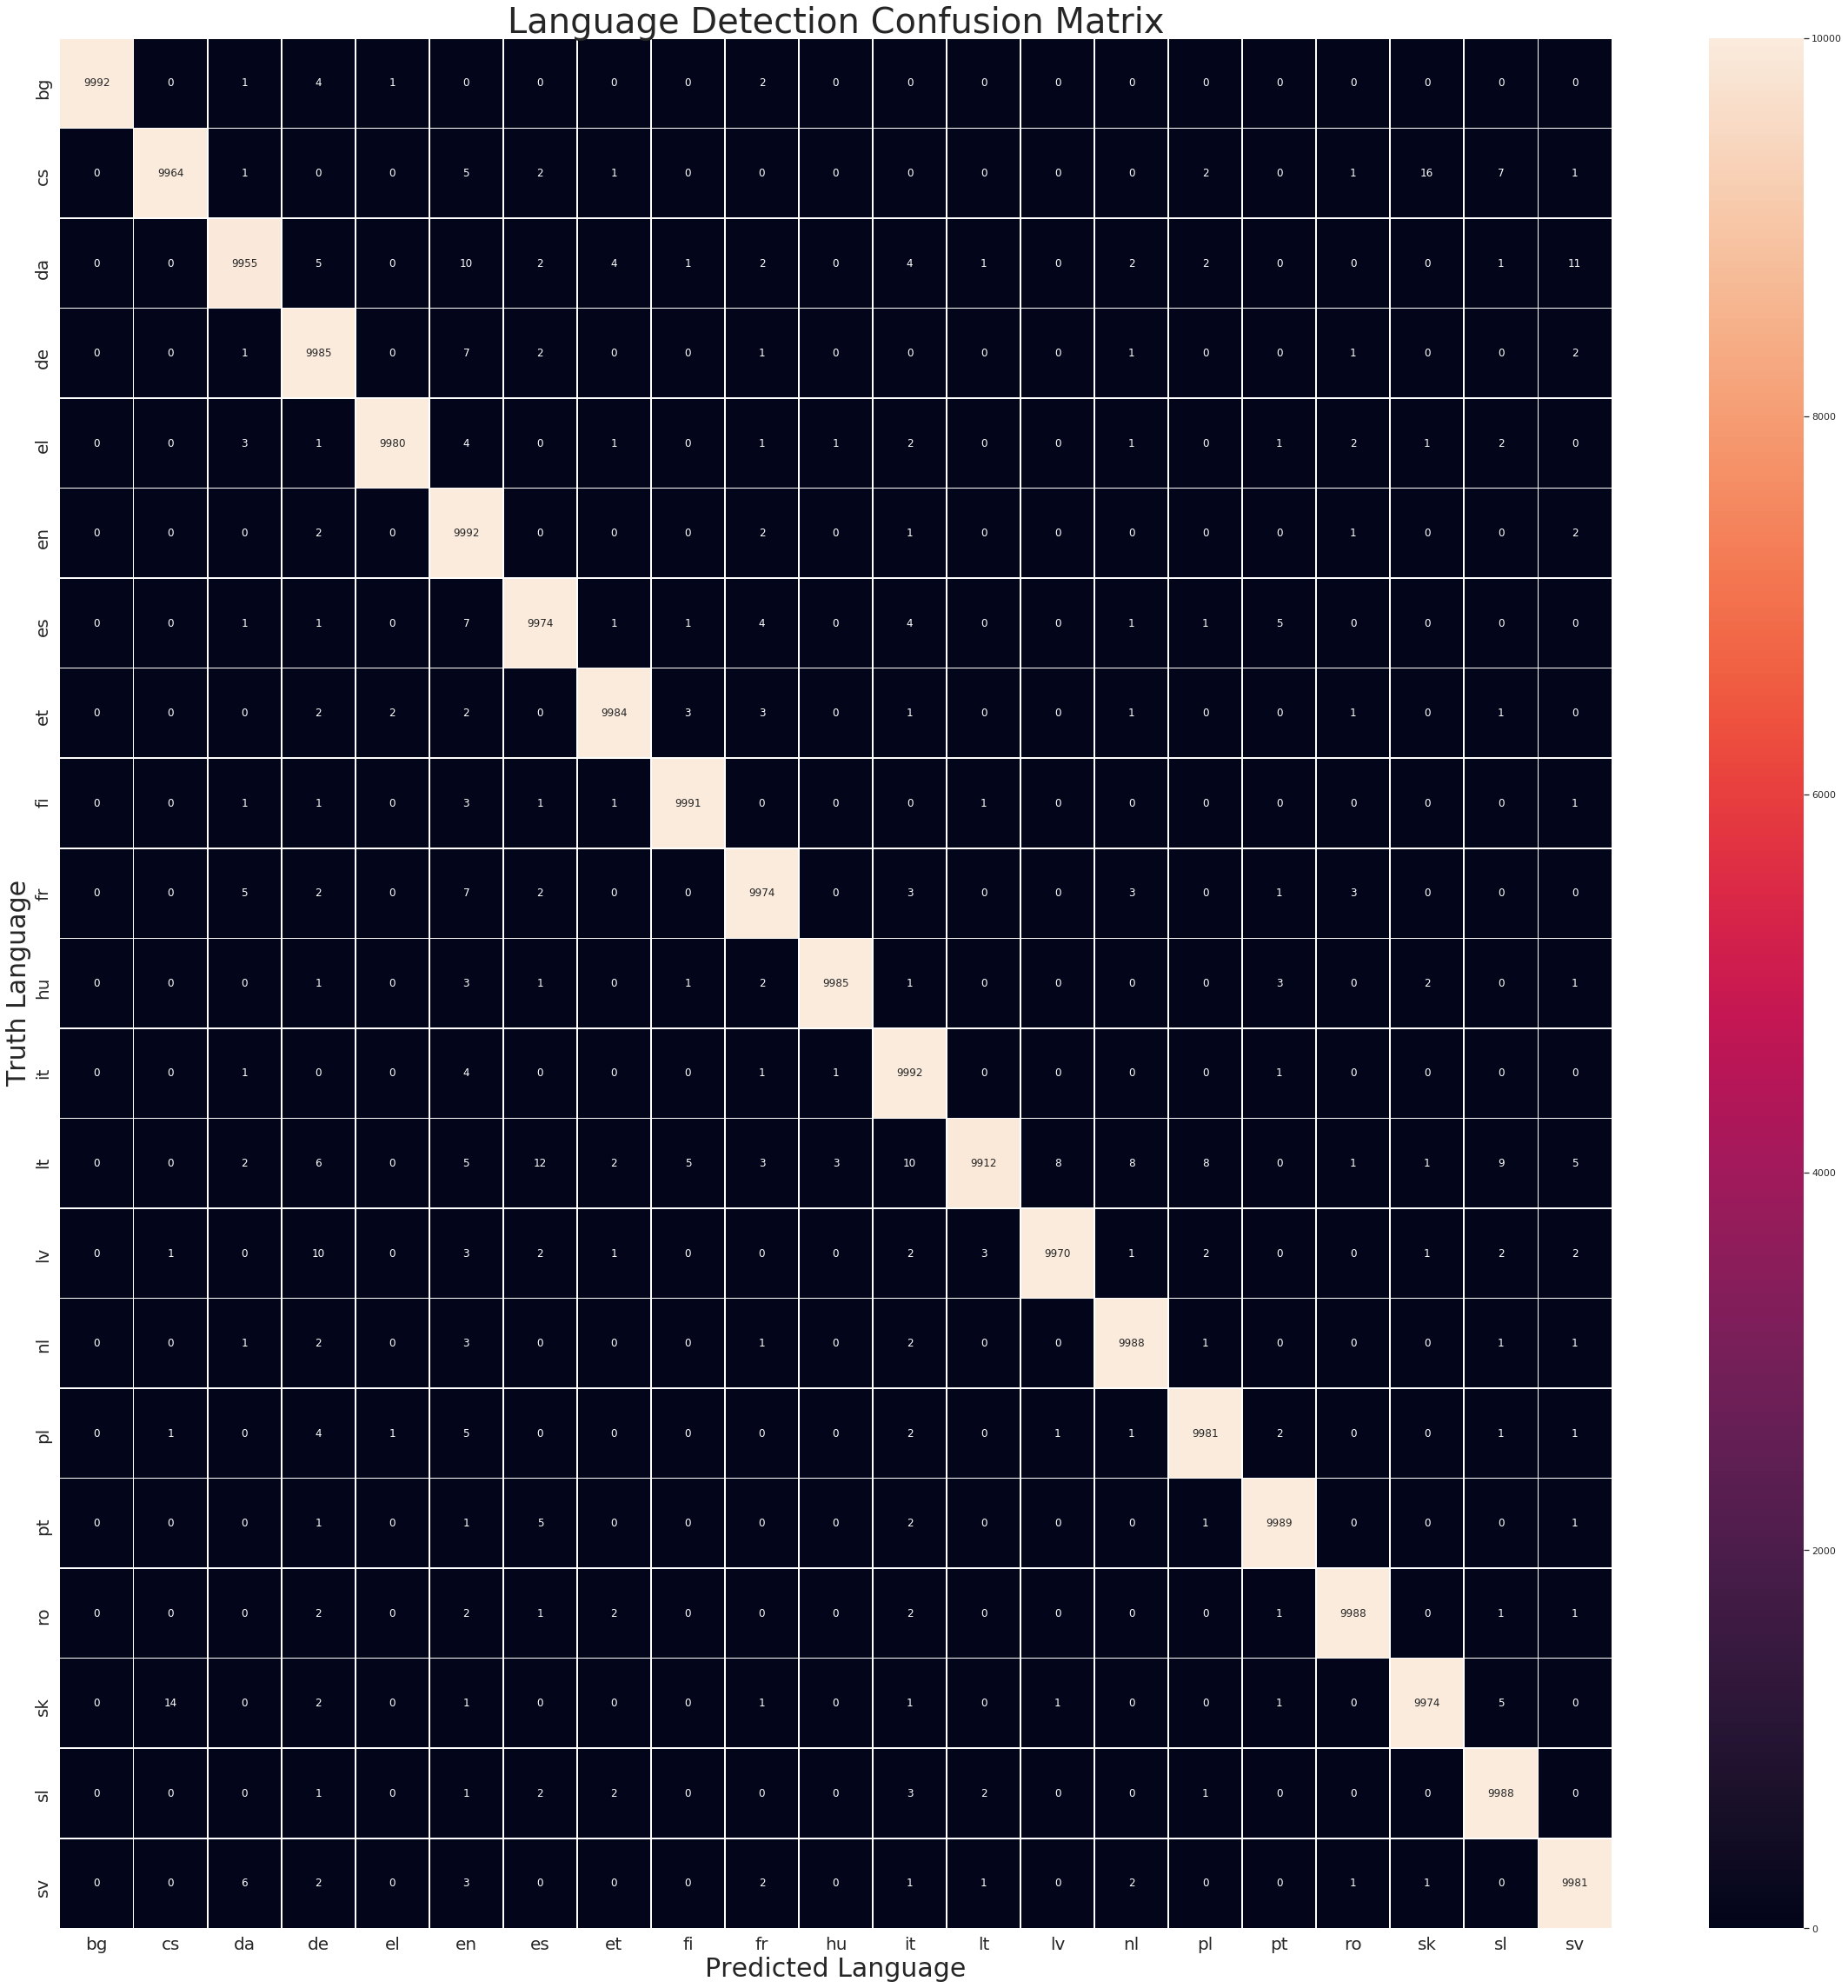

In [10]:
def plot_confusion_matrix(truth_y, pred_y, label):
    plt.figure(figsize=(40, 40))
    confusion_mat = confusion_matrix(truth_y, pred_y, labels = label)
    ax = sns.heatmap(confusion_mat, vmax=10000, annot=True, linecolor='white', linewidths=0.5,  fmt = 'd',\
                     xticklabels = label,  yticklabels = label)
    plt.xlabel('Predicted Language', fontsize=30)
    plt.ylabel('Truth Language', fontsize=30)
    plt.title('Language Detection Confusion Matrix',fontsize=40)
    ax.set_xticklabels(label, fontsize=20)
    ax.set_yticklabels(label, fontsize=20)

plot_confusion_matrix(data['val_y'],prediction, labels)

Finally, we store our ` N-gram + Naive Bayes` model in the `model.pkl` file.

In [11]:
model = {}
model['TfidfVectorizer'] = tfidf_vect
model['MultinomialNB'] = classifier

f = open('model.pkl','wb')
pickle.dump(model, f)
f.close()